# Drawdown 
##### Adapted from Prof. Gretchen Miller, Texas A&M University


### Conceptual setting

<img src="theis_diagram.gif" alt="theis_diagram" width="600"/>

Transmissivity is calculated as: 

$$ T = \frac{Q}{4 \pi (H_0 - H)} *W(u)$$

where

$$u = \frac{r^2S}{4Tt}$$



The equation is implict and we need to solve it iteratively $T$ appears on both sides. The goal is that the curve calculated by the well function matches the data measured, which will allow us to then calculate $T$. 

As a reminder, $W(u)$ is the well function, given as:

$$W(u) = \int_{u}^{\infty} \frac{e^{-a}}{a}\,da$$


## Defining our Paramters and Inputs
First, we need to define our pump test variables, which are the pumping rate ($Q$), in units of m<sup>3</sup>/d, and radius ($r$), in units of m. Be sure to use decimals so that Python knows that these values should be typed as floating points.

In [1]:
Q = 8176.49 # in m3/d
Q = Q/(24*60) #convert to min
r = 91.44 # in m

Now we need to import the data from our pump test and convert it to two 1-D arrays. The first column is expected to contain time values ($t$) in minutes and the second should contain drawdown at those times, ($H_0 - H$), in units of m. The file has no headers.

In [2]:
import csv
import numpy as np

with open('well_test_data.csv',newline='') as csvfile:
    datain = csv.reader(csvfile,quoting = csv.QUOTE_NONNUMERIC)
    data = np.array(list(datain))
print(data)
time = data[:,0]
s_meas = data[:,1] #measured drawdown data

[[1.000000e+00 1.371600e-01]
 [2.000000e+00 2.255520e-01]
 [3.000000e+00 2.773680e-01]
 [4.000000e+00 3.169920e-01]
 [6.000000e+00 3.688080e-01]
 [8.000000e+00 4.023360e-01]
 [1.000000e+01 4.419600e-01]
 [3.000000e+01 6.156960e-01]
 [4.000000e+01 6.614160e-01]
 [5.000000e+01 7.010400e-01]
 [6.000000e+01 7.132320e-01]
 [8.000000e+01 7.620000e-01]
 [1.000000e+02 8.138160e-01]
 [2.000000e+02 9.022080e-01]
 [4.000000e+02 9.906000e-01]
 [6.000000e+02 1.039368e+00]
 [8.000000e+02 1.066800e+00]
 [1.000000e+03 1.097280e+00]
 [1.440000e+03 1.161288e+00]]


Now we can plot our data for reference. Notice how it follows the general shape of the well function that we've seen before.

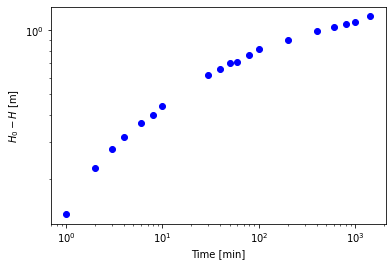

In [3]:
import matplotlib.pyplot as plt
plt.loglog(time, s_meas,'bo')
plt.xlabel('Time [min]')
plt.ylabel('$H_0-H$ [m]')
plt.show()

## Fitting the Well Function to the data

Now what we need to do is fit the Theis equation to this data, which is a multi-step process:
<ol>
<li>Program drawdown equation and well function.</li>
<li>Make an intial guess for the values of transmissvity, $T$, and storativity, $S$.</li>
<li>Calculate drawdown, $s'$, for each measured time based on these guesses. These become the modeled values, or $s'_{mod}$</li>
<li>Compare $s'_{mod}$ to the actual values $s'_{act}$ using an objective function. Here we will use a sum of squared differences metric, $SS$.</li>
<li>Change the values of $T$ and $S$ in a systematic way until $SS$ is minimized. </li>
<li>The values of $T$ and $S$ that give you the minimum $SS$ are your aquifer parameters.</li>   
</ol>

Let's start by making our guesses:

In [4]:
T = 500# in m^2/d
S = 0.001 #unitless

T = T/(24*60) # convert to m/min

Now we need to call a function to calculate the well function from these initial guesses. We can do this by using the infinite series that solves the integral above:

$$W(u) = -0.57721566 - ln(u) + u -\frac{u^2}{2*2!} + \frac{u^3}{3*3!} -\frac{u^4}{4*4!} + ...$$

Then we need to evaluate this well function for the value of u at every time.

In [5]:
uvalues = ((r**2)*S)/(4*T*time)
print(uvalues)

[6.02011699e+00 3.01005850e+00 2.00670566e+00 1.50502925e+00
 1.00335283e+00 7.52514624e-01 6.02011699e-01 2.00670566e-01
 1.50502925e-01 1.20402340e-01 1.00335283e-01 7.52514624e-02
 6.02011699e-02 3.01005850e-02 1.50502925e-02 1.00335283e-02
 7.52514624e-03 6.02011699e-03 4.18063680e-03]


We calculate the modeled drawdown for each time.

In [6]:
import well_fxn_script as wf
tol = 1e-7 #acceptable error for well function calculations
s_mod = list(map(lambda uvalues: wf.well_fxn(uvalues,tol)*Q/(4*T*np.pi),uvalues))
print(s_mod)

[0.0004579218089858537, 0.016764466506696385, 0.06304811959836863, 0.12918888619009603, 0.2838908940684172, 0.4408403410749919, 0.5889090029670748, 1.5875053078281918, 1.90199799254229, 2.155746979401343, 2.3682827895784513, 2.7114010505357586, 2.9828472432223307, 3.8465595346453334, 4.729205904192419, 5.250361634279084, 5.6214806574145, 5.909911866704576, 6.382044777889927]


Now let's see how we did with our first guesses!

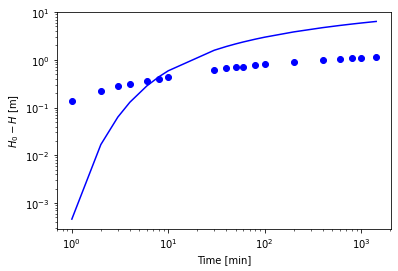

In [7]:
plt.loglog(time, s_mod,'b-',time, s_meas,'bo', )
plt.xlabel('Time [min]')
plt.ylabel('$H_0-H$ [m]')
plt.show()

We calculate the objective function for this as:

$$SS = \sum_{i=1}^{n} (s'_{mod}-s'_{meas})^2 $$

In [8]:
SS = np.sum(np.square(s_mod - s_meas))
print(SS)

127.55914389825942


The value of $SS$ does not have much meaning right now. We want to find the minimum $SS$ value possible, or the least sum of squares, $LSS$. To do this, we are going to need some sort of curve fitting function, like "Solver" in Excel. We don't want to write this from scratch, so we'll use the scipy optimize function. It already has the $LSS$ approach built in, and it is appropriate for a non-linear function like W(u).

In [13]:
from scipy.optimize import curve_fit

def func(t,Tcalc,Scalc):
    tol = 1e-6
    a = len(t)
    s_mod_fit = np.zeros(a)

    for i in range(0, a):
        u = ((r**2)*Scalc)/(4*Tcalc*t[i])
        s_mod_fit[i] = wf.well_fxn(u,tol)*Q/(4*Tcalc*np.pi)
        #print(i)
    return s_mod_fit

[T_final,S_final], dummy = curve_fit(func, time, s_meas, p0=([T,S]), bounds=(0, np.inf))
print(T_final)

3.0919276560549718


## Final Aquifer Parameters
Now, we can create a new plot showing the data with the final curve fit. We rerun the function to calculate the final model and its $SS$ value, which is now much smaller:

In [10]:
uvalues_final = ((r**2)*S_final)/(4*T_final*time)
s_mod_final = list(map(lambda uvalues_final: wf.well_fxn(uvalues_final,tol)*Q/(4*T_final*np.pi),uvalues_final))
SS = np.sum(np.square(s_meas - s_mod_final))
print(SS)

0.0035824512691456957


Finally, we create our plot and label it with our 

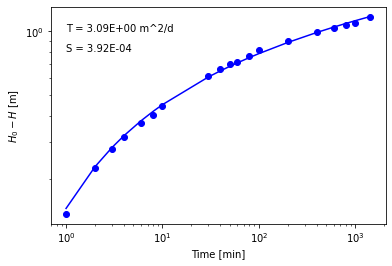

In [11]:
plt.loglog(time, s_mod_final,'b-',time, s_meas,'bo', )
plt.xlabel('Time [min]')
plt.ylabel('$H_0-H$ [m]')
Tstring = "T = "+format(T_final,'.2E') +" m^2/d"
Sstring = "S = " + format(S_final,'.2E')
plt.annotate(Tstring, xy=(1, 1))
plt.annotate(Sstring, xy=(1,0.8))
plt.show()